# Explore here

In [ ]:
# Your code here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

dataframe = pd.read_csv('../data/raw/AB_NYC_2019.csv', delimiter=',')

dataframe.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
if dataframe['name'].duplicated().sum() or dataframe['host_id'].duplicated().sum() or dataframe['id'].duplicated().sum():
    print("There are duplicated rows\n")
    dataframe = dataframe.drop_duplicates()
else:
    print("There are no duplicated rows\n")

dataframe.loc[dataframe['number_of_reviews'] == 0, 'reviews_per_month'] = dataframe.loc[dataframe['number_of_reviews'] == 0, 'reviews_per_month'].fillna(0)

dataframe = dataframe.drop(['id', 'host_id', 'name', 'host_name', 'availability_365', 'calculated_host_listings_count', 'neighbourhood', 'latitude', 'longitude', 'last_review'], axis=1)

dataframe['room_type_n'] = pd.factorize(dataframe['room_type'])[0]
dataframe = dataframe[dataframe['minimum_nights'] <= 15 ]
dataframe = dataframe[dataframe['price'] > 0]

if dataframe.isna().sum().sum():
    dataframe = dataframe.dropna(axis=1)

dataframe.describe()

There are duplicated rows



,price,minimum_nights,number_of_reviews,reviews_per_month,room_type_n
count,43265.000000,43265.000000,43265.000000,43265.000000,43265.000000
mean,148.807859,2.962857,25.211950,1.192939,0.546932
std,210.776500,2.500413,46.292011,1.656583,0.544161
min,10.000000,1.000000,0.000000,0.000000,0.000000
25%,69.000000,1.000000,1.000000,0.050000,0.000000
50%,100.000000,2.000000,6.000000,0.470000,1.000000
75%,175.000000,4.000000,27.000000,1.820000,1.000000
max,10000.000000,15.000000,629.000000,58.500000,2.000000


In [46]:
# Detect outliers in numerical columns using the IQR method.

outlier_counts = {}
numeric_cols = dataframe.select_dtypes('number')

for col in numeric_cols:
    Q1 = dataframe[col].quantile(0.25)
    Q3 = dataframe[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
    outlier_counts[col] = outliers.shape[0]
    
outliers = {col: count for col, count in outlier_counts.items() if count > 0}

print(outliers)

{'price': 2584, 'minimum_nights': 1582, 'number_of_reviews': 5106, 'reviews_per_month': 2180}


In [47]:
# Apply transformations to reduce outliers' impact on numerical columns

df_transformed = dataframe.copy()

for col in outliers.keys():
    #"log":
    df_transformed[col] = np.log1p(dataframe[col])
    #"sqrt":
    #df_transformed[col] = np.sqrt(dataframe[col])
    #elif method == "boxcox":
    #df_transformed[col], _ = boxcox(dataframe[col] + 1)

df_transformed.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,room_type_n
count,43265.000000,43265.000000,43265.000000,43265.000000,43265.000000
mean,4.726745,1.239372,2.099085,0.586404,0.546932
std,0.680617,0.491397,1.565182,0.590099,0.544161
min,2.397895,0.693147,0.000000,0.000000,0.000000
25%,4.248495,0.693147,0.693147,0.048790,0.000000
50%,4.615121,1.098612,1.945910,0.385262,1.000000
75%,5.170484,1.609438,3.332205,1.036737,1.000000
max,9.210440,2.772589,6.445720,4.085976,2.000000


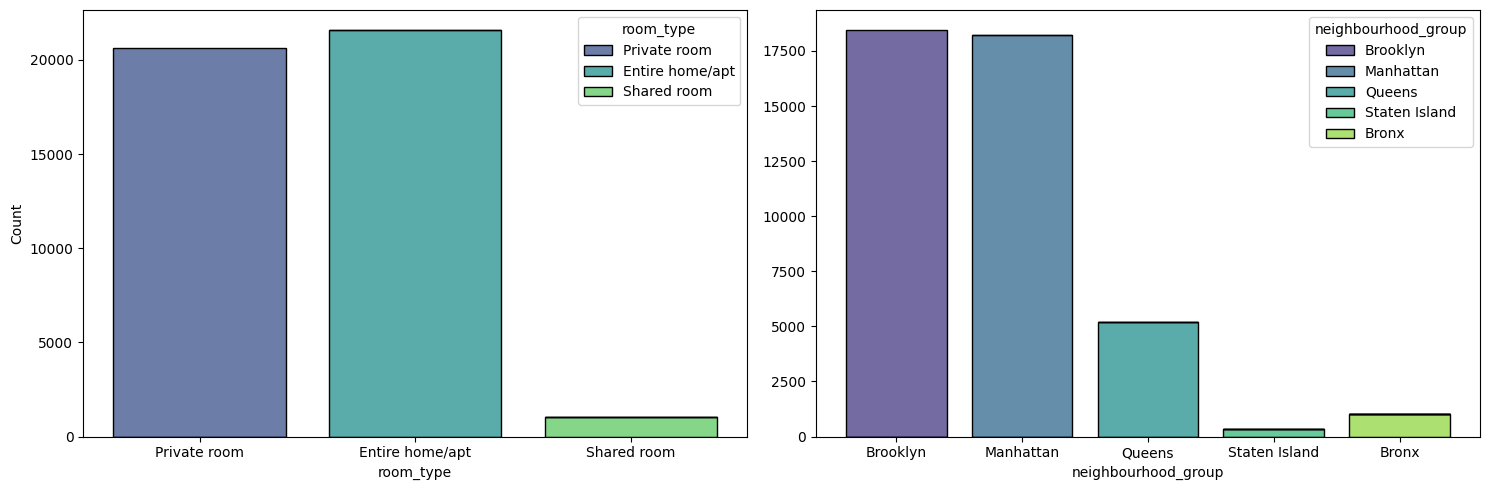

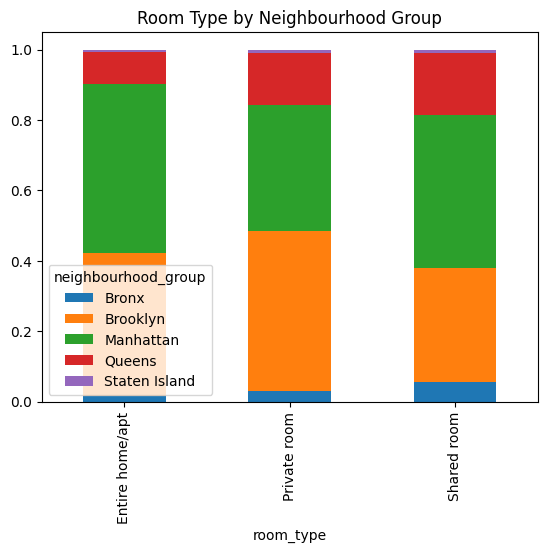

In [48]:
train_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=42)

""" Análisis de variables categóricas """
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=ax1, data=dataframe, x='room_type', hue='room_type', multiple='stack', shrink=.8, palette='viridis')
sns.histplot(ax=ax2, data=dataframe, x='neighbourhood_group', hue='neighbourhood_group', multiple='stack', shrink=.8, palette='viridis').set_ylabel(None)
plt.tight_layout()
plt.show()

pd.crosstab(dataframe['room_type'], dataframe['neighbourhood_group'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Room Type by Neighbourhood Group")
plt.show()


# Bar Plot Analysis for room_type:

    Distribution:

        The room types are categorized into three groups: Private room, Entire home/apt, and Shared room.

        Private room: Around 20,000 listings.

        Entire home/apt: Also around 20,000 listings.

        Shared room: Significantly fewer listings, around 2,500.

Interpretation:

    The majority of listings are either for Private rooms or Entire homes/apartments, with similar counts.

    Shared rooms are much less common, indicating a lower availability or demand for this type of accommodation.


# Bar Plot Analysis for neighbourhood_group:

    Distribution:

        The neighbourhood groups are Brooklyn, Manhattan, Queens, Staten Island, and Bronx.

        Brooklyn and Manhattan: Both have the highest counts, around 18,000 listings each.

        Queens: Approximately 7,500 listings.

        Staten Island: Around 1,000 listings.

        Bronx: Around 2,500 listings.

Interpretation:

    Brooklyn and Manhattan dominate the listings, suggesting these areas are the most popular or have the most properties available for rent.

    Queens also has a substantial number of listings, while Staten Island and the Bronx have considerably fewer.

Stacked Bar Plot Analysis:

    This plot shows the distribution of room_type across different neighbourhood_group.

    Brooklyn and Manhattan: Primarily consist of Private rooms and Entire homes/apartments, with very few Shared rooms.

    Queens: Similar to Brooklyn and Manhattan but with slightly fewer Entire homes/apartments.

    Staten Island: Predominantly Private rooms and Shared rooms.

    Bronx: More varied distribution with a noticeable presence of Shared rooms.

Interpretation:

    The distribution of room types varies by neighbourhood group.

    High availability of Private rooms and Entire homes/apartments in Brooklyn and Manhattan suggests these areas are more suited for travelers seeking these types of accommodations.

    The presence of Shared rooms is more prominent in Bronx and Staten Island, which could indicate a preference or higher demand for more affordable options in these areas.

# General Conclusions:

    Room Type Availability:

        Private rooms and Entire homes/apartments are the most common room types.

        Shared rooms are less common but still available, with the highest presence in Bronx and Staten Island.

    Neighbourhood Group Popularity:

        Brooklyn and Manhattan have the highest number of listings, indicating these areas are more popular or have more properties available for rent.

        Queens also has a significant number of listings, while Staten Island and Bronx have fewer.

    Room Type by Neighbourhood Group:

        The distribution of room types varies across different neighbourhood groups, which can provide insights into market demand and preferences for different accommodation types in various areas.

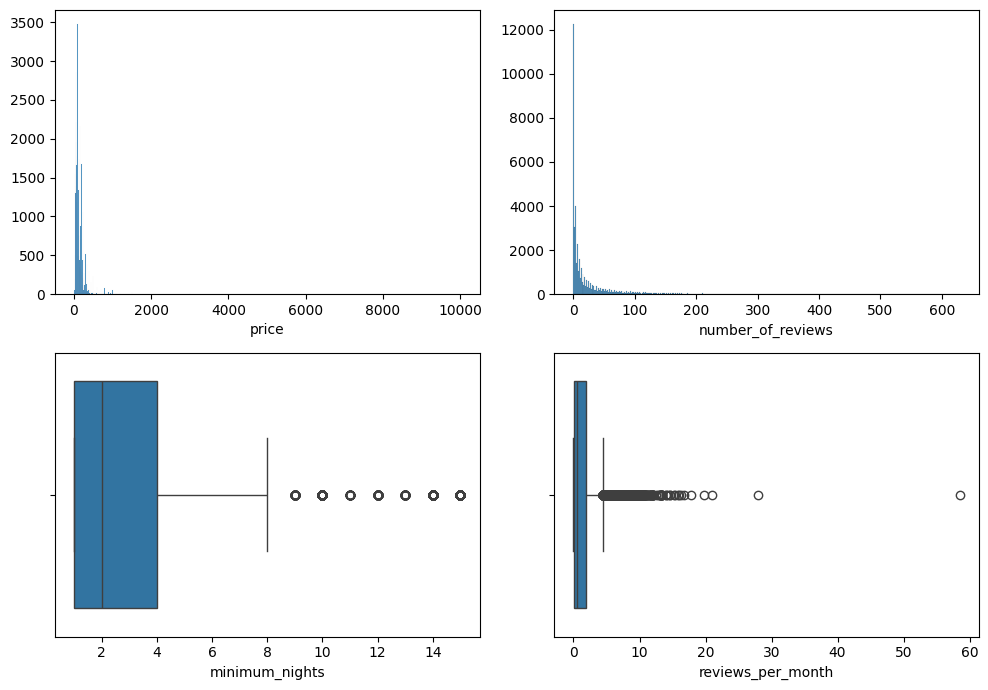

In [49]:
""" Análisis de variables numéricas """
_, axis = plt.subplots(2, 2, figsize = (10, 7))
sns.histplot(ax = axis[0,0], data = dataframe, x = "price").set_ylabel(None)
sns.boxplot(ax = axis[1,0], data = dataframe, x = "minimum_nights").set_ylabel(None)
sns.histplot(ax = axis[0,1], data = dataframe, x = "number_of_reviews").set_ylabel(None)
sns.boxplot(ax = axis[1,1], data = dataframe, x = "reviews_per_month").set_ylabel(None)
plt.tight_layout()
plt.show()

1. Price

    Histogram:

        Distribution: The majority of prices are clustered at the lower end of the range, with a long tail extending towards higher prices.

        Skewness: The distribution is right-skewed, indicating that while most prices are low, there are some significantly higher prices.

        Mode: Most listings have a lower price range.

    Box Plot:

        Outliers: Several high-value outliers are present, indicating some listings are priced significantly higher than the majority.

        Median: The median price is relatively low compared to the outliers.

2. Number of Reviews

    Histogram:

        Distribution: Most listings have a low number of reviews, with a long tail extending towards listings with a higher number of reviews.

        Skewness: The distribution is right-skewed, suggesting that a few listings receive a lot of reviews while most get few.

    Box Plot:

        Outliers: Several outliers with high numbers of reviews.

        Median: The median number of reviews is low, confirming that most listings do not receive many reviews.

3. Minimum Nights

    Histogram:

        Distribution: The majority of listings have a minimum stay requirement between 1 and 4 nights.

        Skewness: There are some longer minimum stays, but they are less common.

    Box Plot:

        Outliers: Several outliers with long minimum stay requirements.

        Median: The median minimum nights requirement is low, indicating that most listings have flexible short stays.

4. Reviews per Month

    Histogram:

        Distribution: Most listings receive a low number of reviews per month, with a long tail extending towards listings that receive more reviews.

        Skewness: The distribution is right-skewed, indicating that while most listings get few reviews monthly, some receive significantly more.

    Box Plot:

        Outliers: Some listings have a high number of reviews per month, marking them as outliers.

        Median: The median number of reviews per month is low, showing that frequent reviews are not common.

# General Conclusions:

    Price and Number of Reviews: Both variables show a right-skewed distribution with many lower values and some high outliers. This suggests that while most listings are affordable and receive few reviews, a minority are more expensive and highly reviewed.

    Minimum Nights: The distribution shows that most hosts allow short stays, but some listings have longer minimum stay requirements.

    Reviews per Month: The data indicates that most listings do not get frequent reviews, but a few get a high number of reviews each month, possibly indicating higher popularity or turnover.

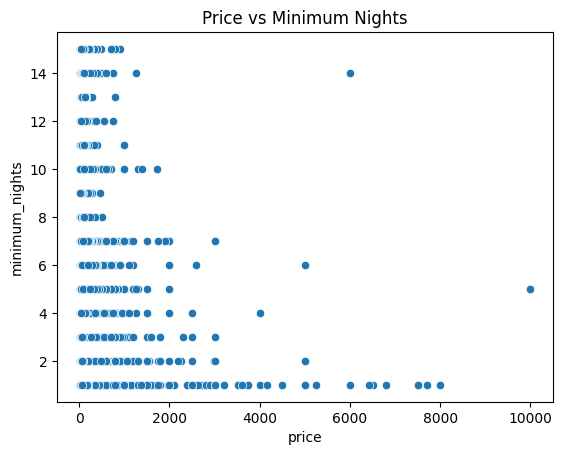

In [50]:
sns.scatterplot(data=dataframe, x='price', y='minimum_nights')
plt.title("Price vs Minimum Nights")
plt.show()

Title: Price vs Minimum Nights

Description:

    The scatter plot shows the relationship between price (on the x-axis) and minimum_nights (on the y-axis).

    The x-axis ranges from 0 to 10,000, and the y-axis ranges from 0 to 15.

    Each point on the plot represents a combination of price and minimum_nights for different listings.

Key Observations:

    Data Clustering:

        The majority of the data points are clustered towards the lower end of both axes. This indicates that most listings have lower prices and fewer minimum nights requirements.

        The densest cluster appears to be within the range of price from 0 to 500 and minimum_nights from 0 to 5.

    Outliers:

        There are a few outliers with higher prices (up to 10,000) and varying minimum nights.

        These outliers suggest that there are some listings with significantly higher prices and different minimum stay requirements, which could be luxury listings or properties in high-demand areas.

    Relationship Between Variables:

        The plot shows a weak positive relationship between price and minimum_nights. As the minimum nights requirement increases, the price tends to increase slightly, but the relationship is not very strong.

Interpretation:

    Price Strategy: Most hosts set lower prices for shorter minimum stay requirements, making their listings more attractive to a wider range of potential guests.

    High-End Listings: The outliers with high prices and varying minimum nights might be luxury properties or listings in popular areas with high demand.

    Booking Flexibility: The weak positive relationship suggests that while some hosts might increase the price for longer minimum stays, many hosts keep prices relatively low regardless of the minimum stay requirement.

General Conclusions:

    Market Trends: The clustering of lower prices and shorter minimum stay requirements indicates a competitive market where affordability and flexibility are key factors for attracting guests.

    Outlier Impact: The presence of outliers with high prices and varying minimum nights might skew the overall analysis, but they represent a smaller portion of the market.

    Pricing and Policy Strategy: Hosts might benefit from analyzing these trends to set competitive prices and minimum stay requirements that align with market demand.

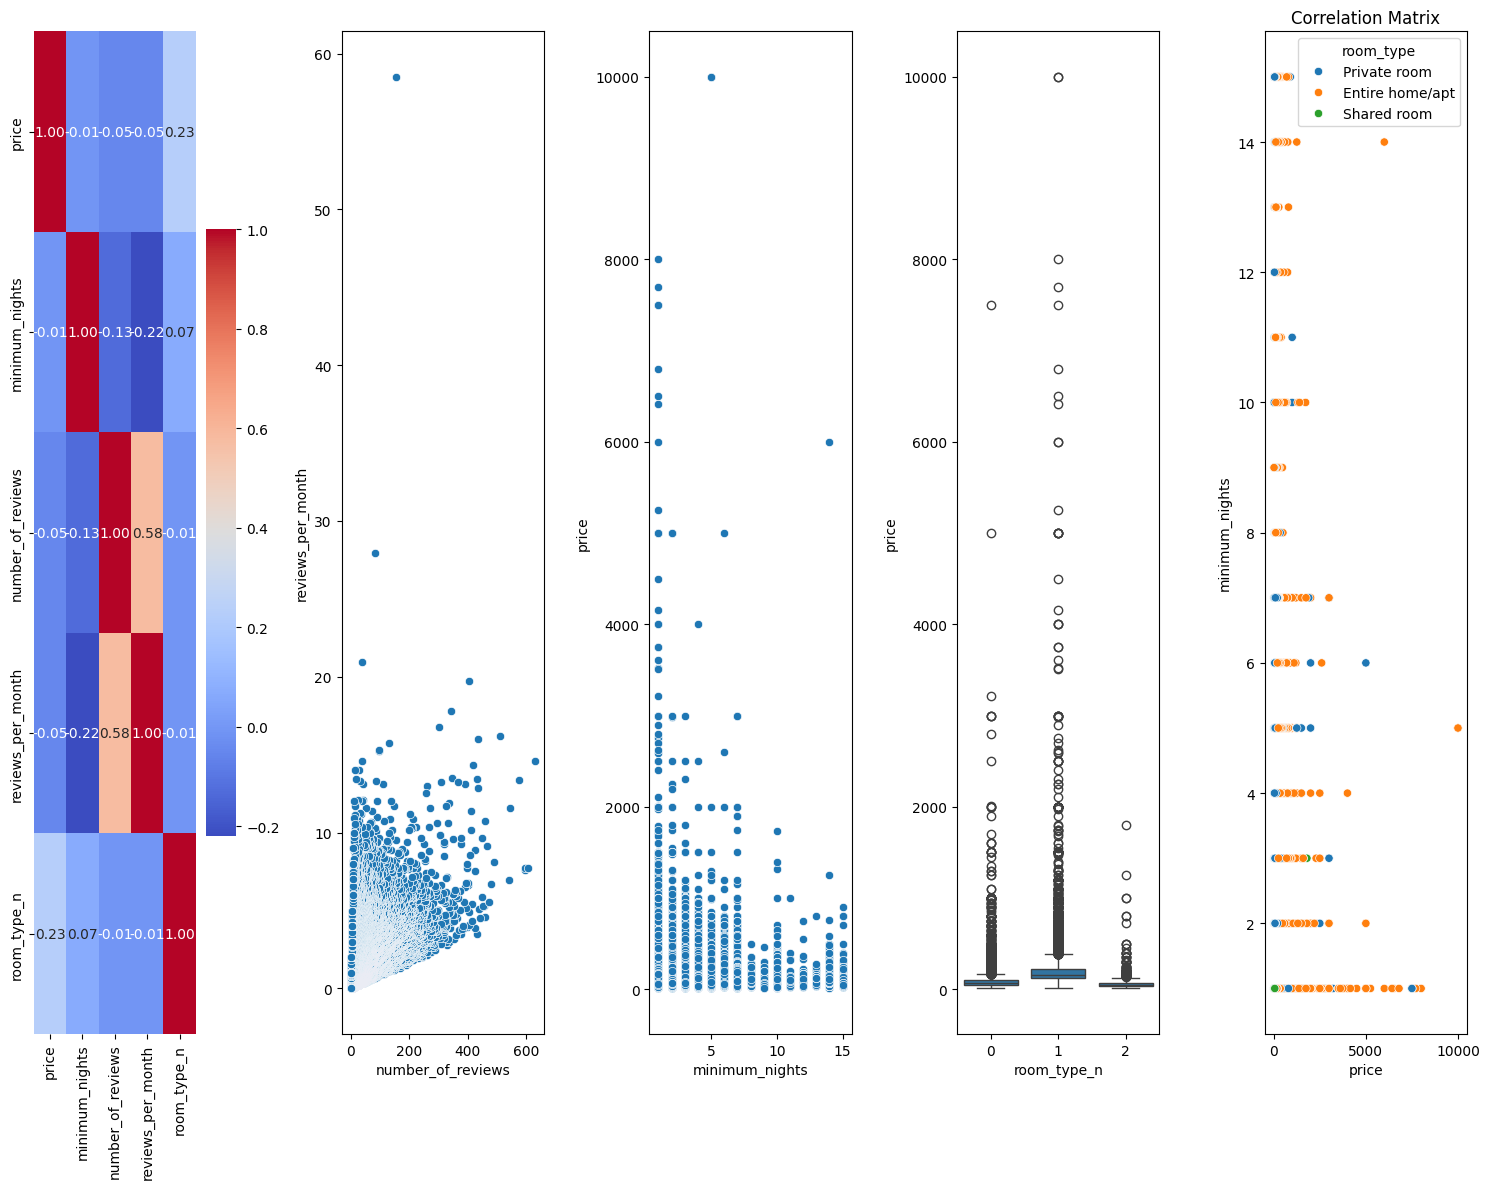

In [51]:
""" Análisis de correlación """
_, axis = plt.subplots(1, 5, figsize = (15, 12))
sns.heatmap(dataframe.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", ax=axis[0])
sns.scatterplot(data=dataframe, x='number_of_reviews', y='reviews_per_month', ax=axis[1])
sns.scatterplot(data=dataframe, x='minimum_nights', y='price', ax=axis[2])
sns.boxplot(data=dataframe, x='room_type_n', y='price', ax=axis[3])
sns.scatterplot(data=dataframe, x='price', y='minimum_nights', hue='room_type', ax=axis[4])
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

1. Correlation Matrix Heatmap

    Description: The heatmap shows the correlation coefficients between different variables: price, minimum_nights, number_of_reviews, reviews_per_month, and room_type_n.

    Key Observations:

        Price vs. Room Type (room_type_n): Correlation coefficient of 0.23. This suggests a moderate positive relationship, indicating that certain room types may have higher prices.

        Price vs. Minimum Nights: Correlation coefficient of 0.05, indicating a very weak positive relationship. This suggests that price and minimum nights are not strongly correlated.

        Number of Reviews vs. Reviews per Month: There is a positive correlation between the number of reviews and reviews per month, indicating that listings with more reviews tend to receive more reviews per month.

2. Scatter Plot: Number of Reviews vs. Reviews per Month

    Description: The scatter plot shows the relationship between the number_of_reviews (x-axis) and reviews_per_month (y-axis).

    Key Observations:

        The plot shows a positive correlation, with more reviews generally leading to more reviews per month.

        Listings with higher numbers of reviews tend to have more consistent monthly reviews, suggesting popularity or consistent guest feedback.

3. Scatter Plot: Minimum Nights vs. Price

    Description: The scatter plot shows the relationship between minimum_nights (x-axis) and price (y-axis).

    Key Observations:

        There is a wide range of prices for different minimum nights, indicating variability in pricing strategies.

        Some outliers have very high prices, suggesting luxury or premium listings.

4. Box Plot: Distribution of Prices by Room Type

    Description: The box plot shows the distribution of prices across different room_type_n (0 for Private room, 1 for Entire home/apt, and 2 for Shared room).

    Key Observations:

        Entire Home/Apt: Generally has higher prices compared to Private rooms and Shared rooms, as indicated by higher medians and upper quartiles.

        Private Room: Prices are lower on average but still vary.

        Shared Room: The lowest price range, with fewer outliers.

5. Scatter Plot: Price vs. Minimum Nights by Room Type

    Description: The scatter plot shows the relationship between price (x-axis) and minimum_nights (y-axis), with different colors representing different room types (blue for Private rooms, orange for Entire home/apt, and green for Shared rooms).

    Key Observations:

        Private Room (Blue): A wide range of prices with mostly lower minimum nights.

        Entire Home/Apt (Orange): Generally higher prices with varied minimum nights.

        Shared Room (Green): Lower prices and shorter minimum nights, indicating more budget-friendly options.

General Conclusions

    Room Types and Pricing: Entire homes/apartments generally have higher prices, while shared rooms are more affordable.

    Reviews Impact: Listings with more reviews tend to receive more monthly reviews, indicating popularity and possibly better guest experiences.

    Pricing Strategies: There is significant variability in pricing strategies, with some listings having high prices regardless of minimum nights, likely indicating luxury properties.